# Busqueda features en titulo y descripcion

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
pd.set_option('display.max_columns', 50)

In [10]:
df = pd.read_csv('../data/train.csv',dtype={'tipodepropiedad':'category','ciudad':'category','provincia':'category'})
df['fecha'] = pd.to_datetime(df['fecha'])
df['anio'] = df['fecha'].dt.year
df["mes"] = df['fecha'].dt.month
df["dia"] = df['fecha'].dt.day

df = df.drop(columns=["lat","lng"])

df["descripcion"] = df["descripcion"].fillna("")
df["titulo"] = df["titulo"].fillna("")

In [11]:
import re
def contiene_frase(texto, frase):
    if re.search(frase, texto,re.IGNORECASE):
        return 1
    return 0

contiene_frase=np.vectorize(contiene_frase)

In [12]:
def cantidad_de_publicaciones(data, columna, palabra):
    return data[contiene_frase(data[columna], palabra)].dia.count()

def serie_que_contiene_palabra(data, columna, palabra):
    return contiene_frase(data[columna], palabra)

## Wordclouds

Para saber qué palabras pueden sernos de interes, hacemos wordclouds para guiarnos

In [13]:
from wordcloud import WordCloud, STOPWORDS
    
def wordcloud_freq(data):

    text = data
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = STOPWORDS).generate_from_frequencies(frequencies=data)
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [14]:
# stopwords son palabras que no nos interesan en nuestro analisis
from stop_words import get_stop_words

stop_words = get_stop_words('spanish')

stopwords = ["en", "a", "al", "de", "la", "y", "el", "del", "las", "los", "-"]

stopwords.extend(stop_words)
stopwords.extend(STOPWORDS)

### Wordcloud título

In [15]:
palabras_titulo = pd.Series([palabra.replace("\'", "") for titulos in df["titulo"] for palabra in titulos.split()])

In [16]:
dict_palabras_titulo = palabras_titulo.loc[~palabras_titulo.isin(stopwords)].groupby(palabras_titulo).size().to_dict()

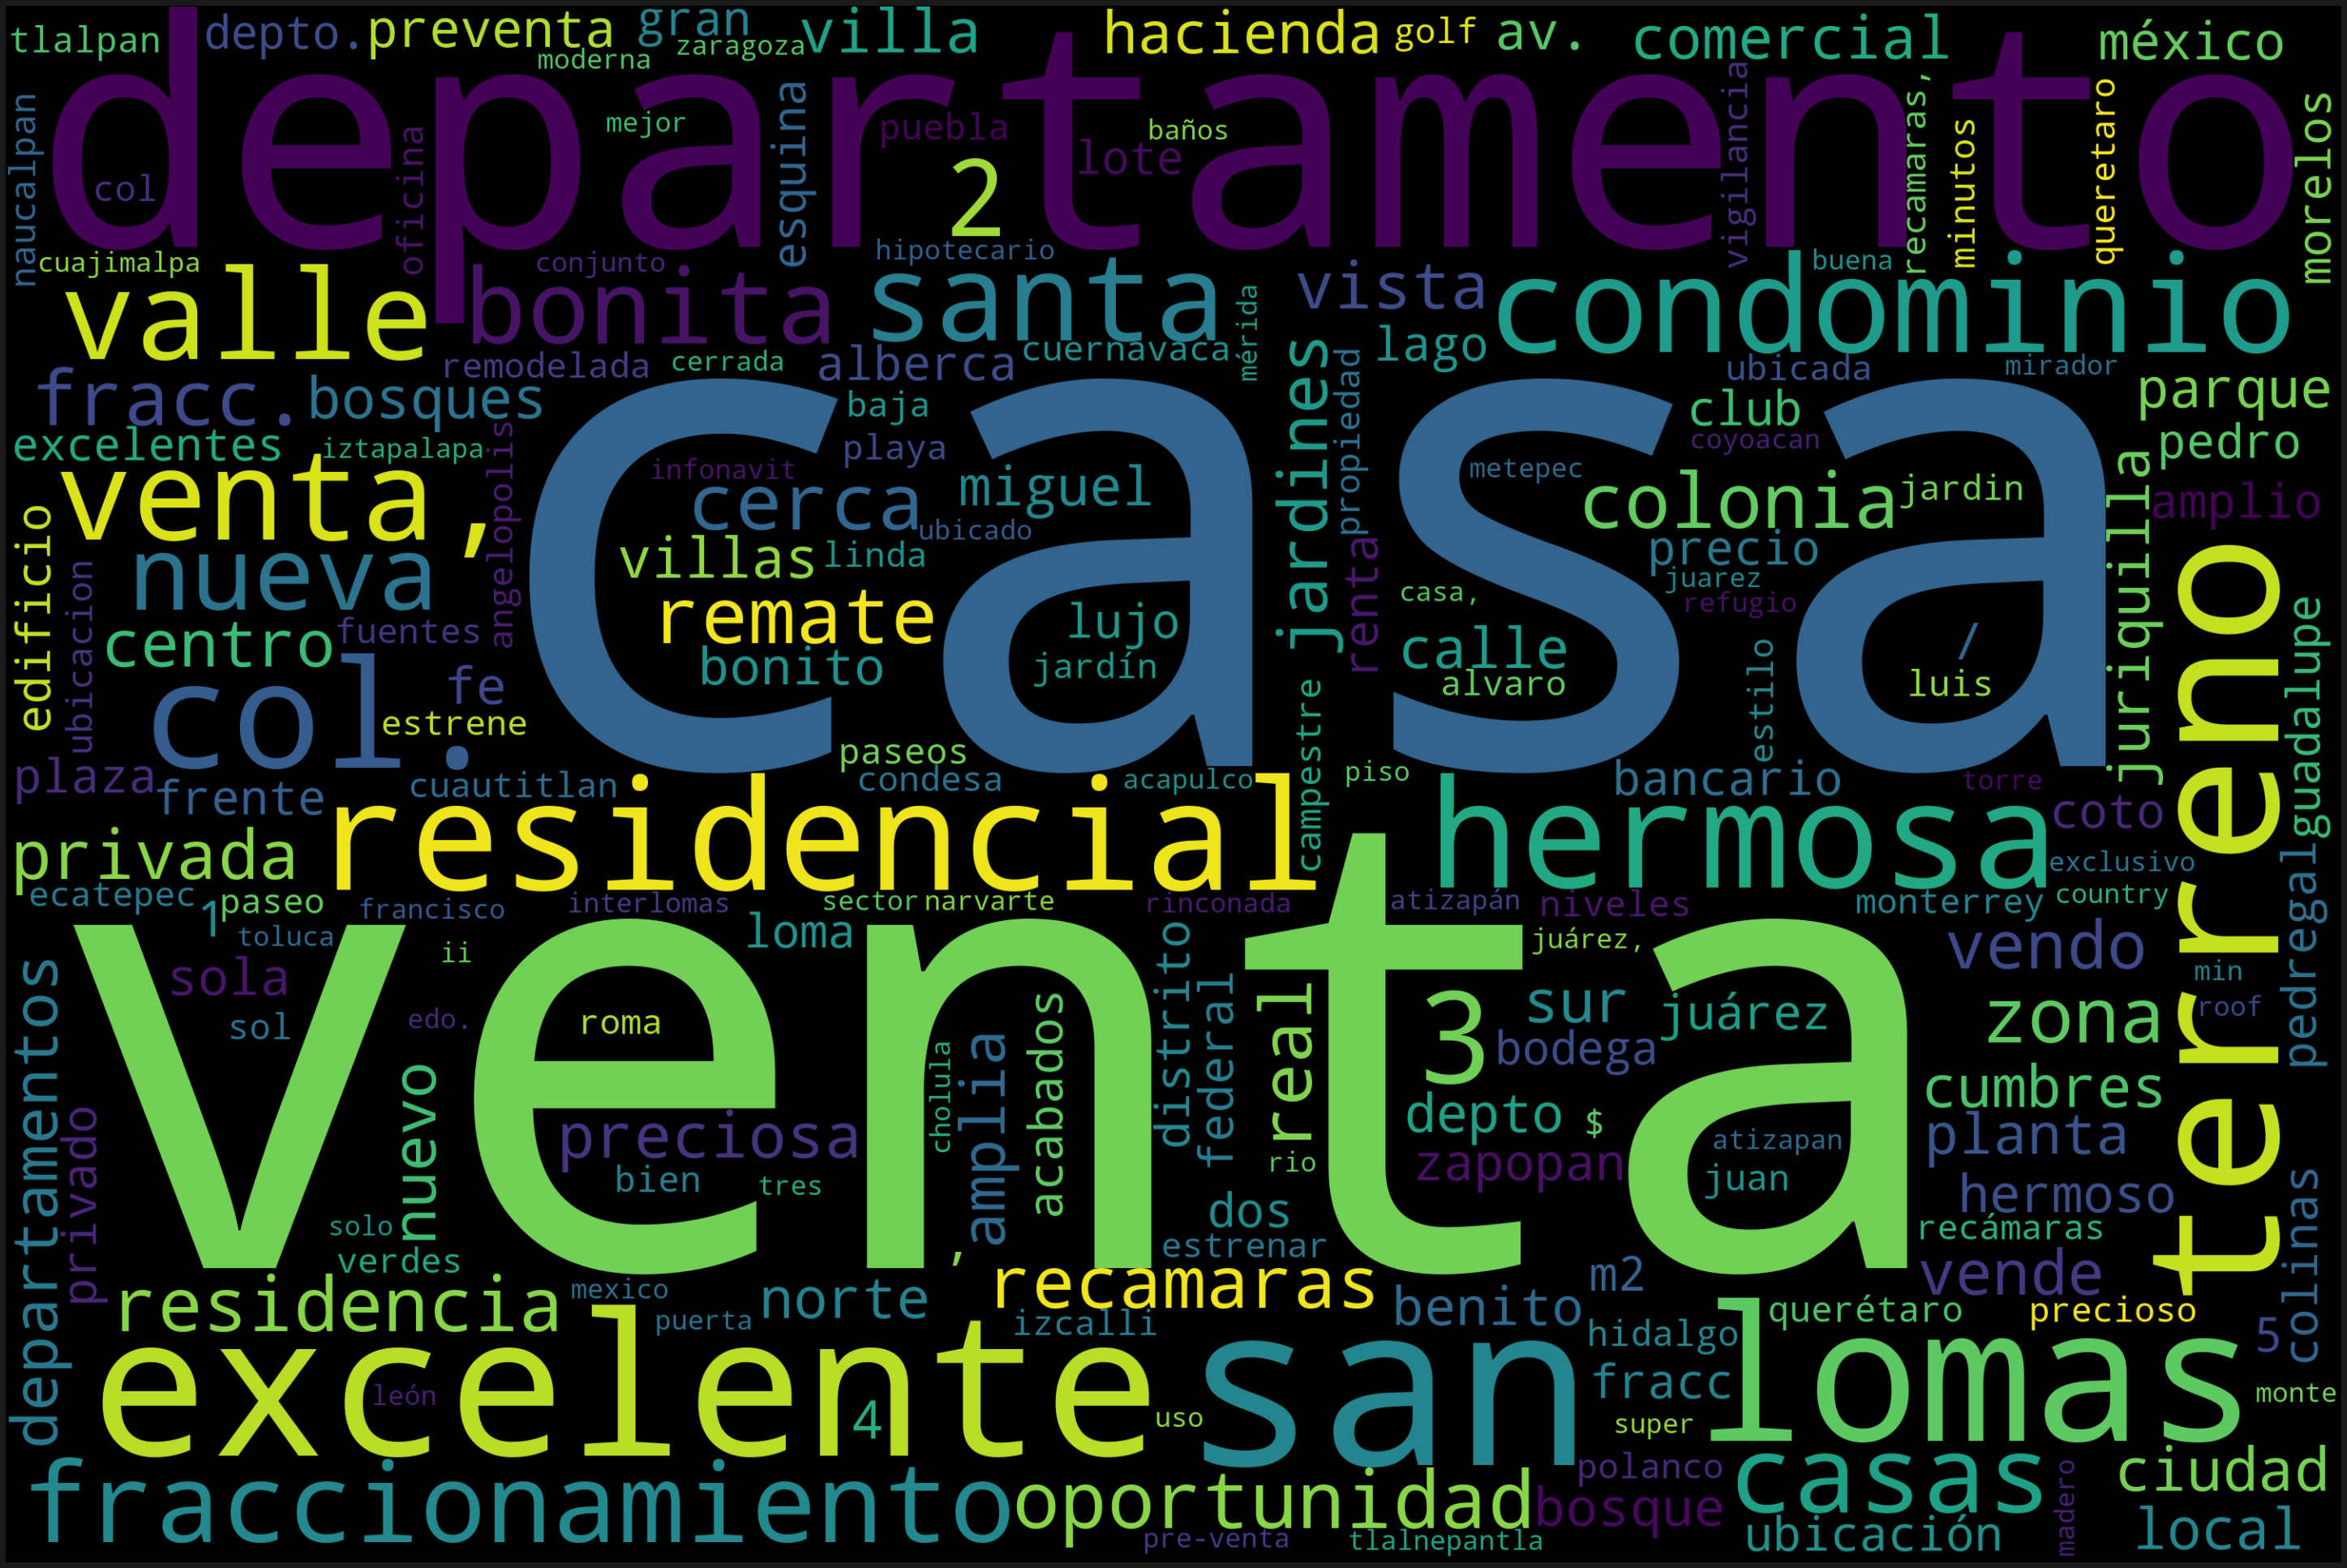

In [17]:
wordcloud_freq(dict_palabras_titulo)

In [18]:
#series_palabras_titulo = df["titulo"].str.split().apply(pd.Series).unstack().dropna().str.replace("\'", "")

In [19]:
#wordcloud_freq(series_palabras_titulo.loc[~series_palabras_titulo.isin(stopwords)].value_counts().to_dict())

In [20]:
#del series_palabras_titulo

### Wordcloud descripción

In [21]:
# NO USAR. SUPER INEFICIENTE HACER EL APPLY, ES GIGANTE series_palabras_descripcion = df["descripcion"].str.split().apply(pd.Series).unstack().dropna().str.replace("\'", "")

In [22]:
#reg = re.compile(re.escape('.*[!|&nbsp;|<p>|</p>|.|<em>|</em>|<strong>|</strong>|<br>|<li>|</li>|www|\n].*'), re.IGNORECASE)
#df["descripcion"].str.replace(reg, '', regex=True)

In [23]:
palabras_descripcion = pd.Series([palabra for descripcion in df["descripcion"] for palabra in descripcion.split()])

In [24]:
dict_palabras_descripcion = palabras_descripcion.loc[~palabras_descripcion.isin(stopwords)].groupby(palabras_descripcion).size().to_dict()

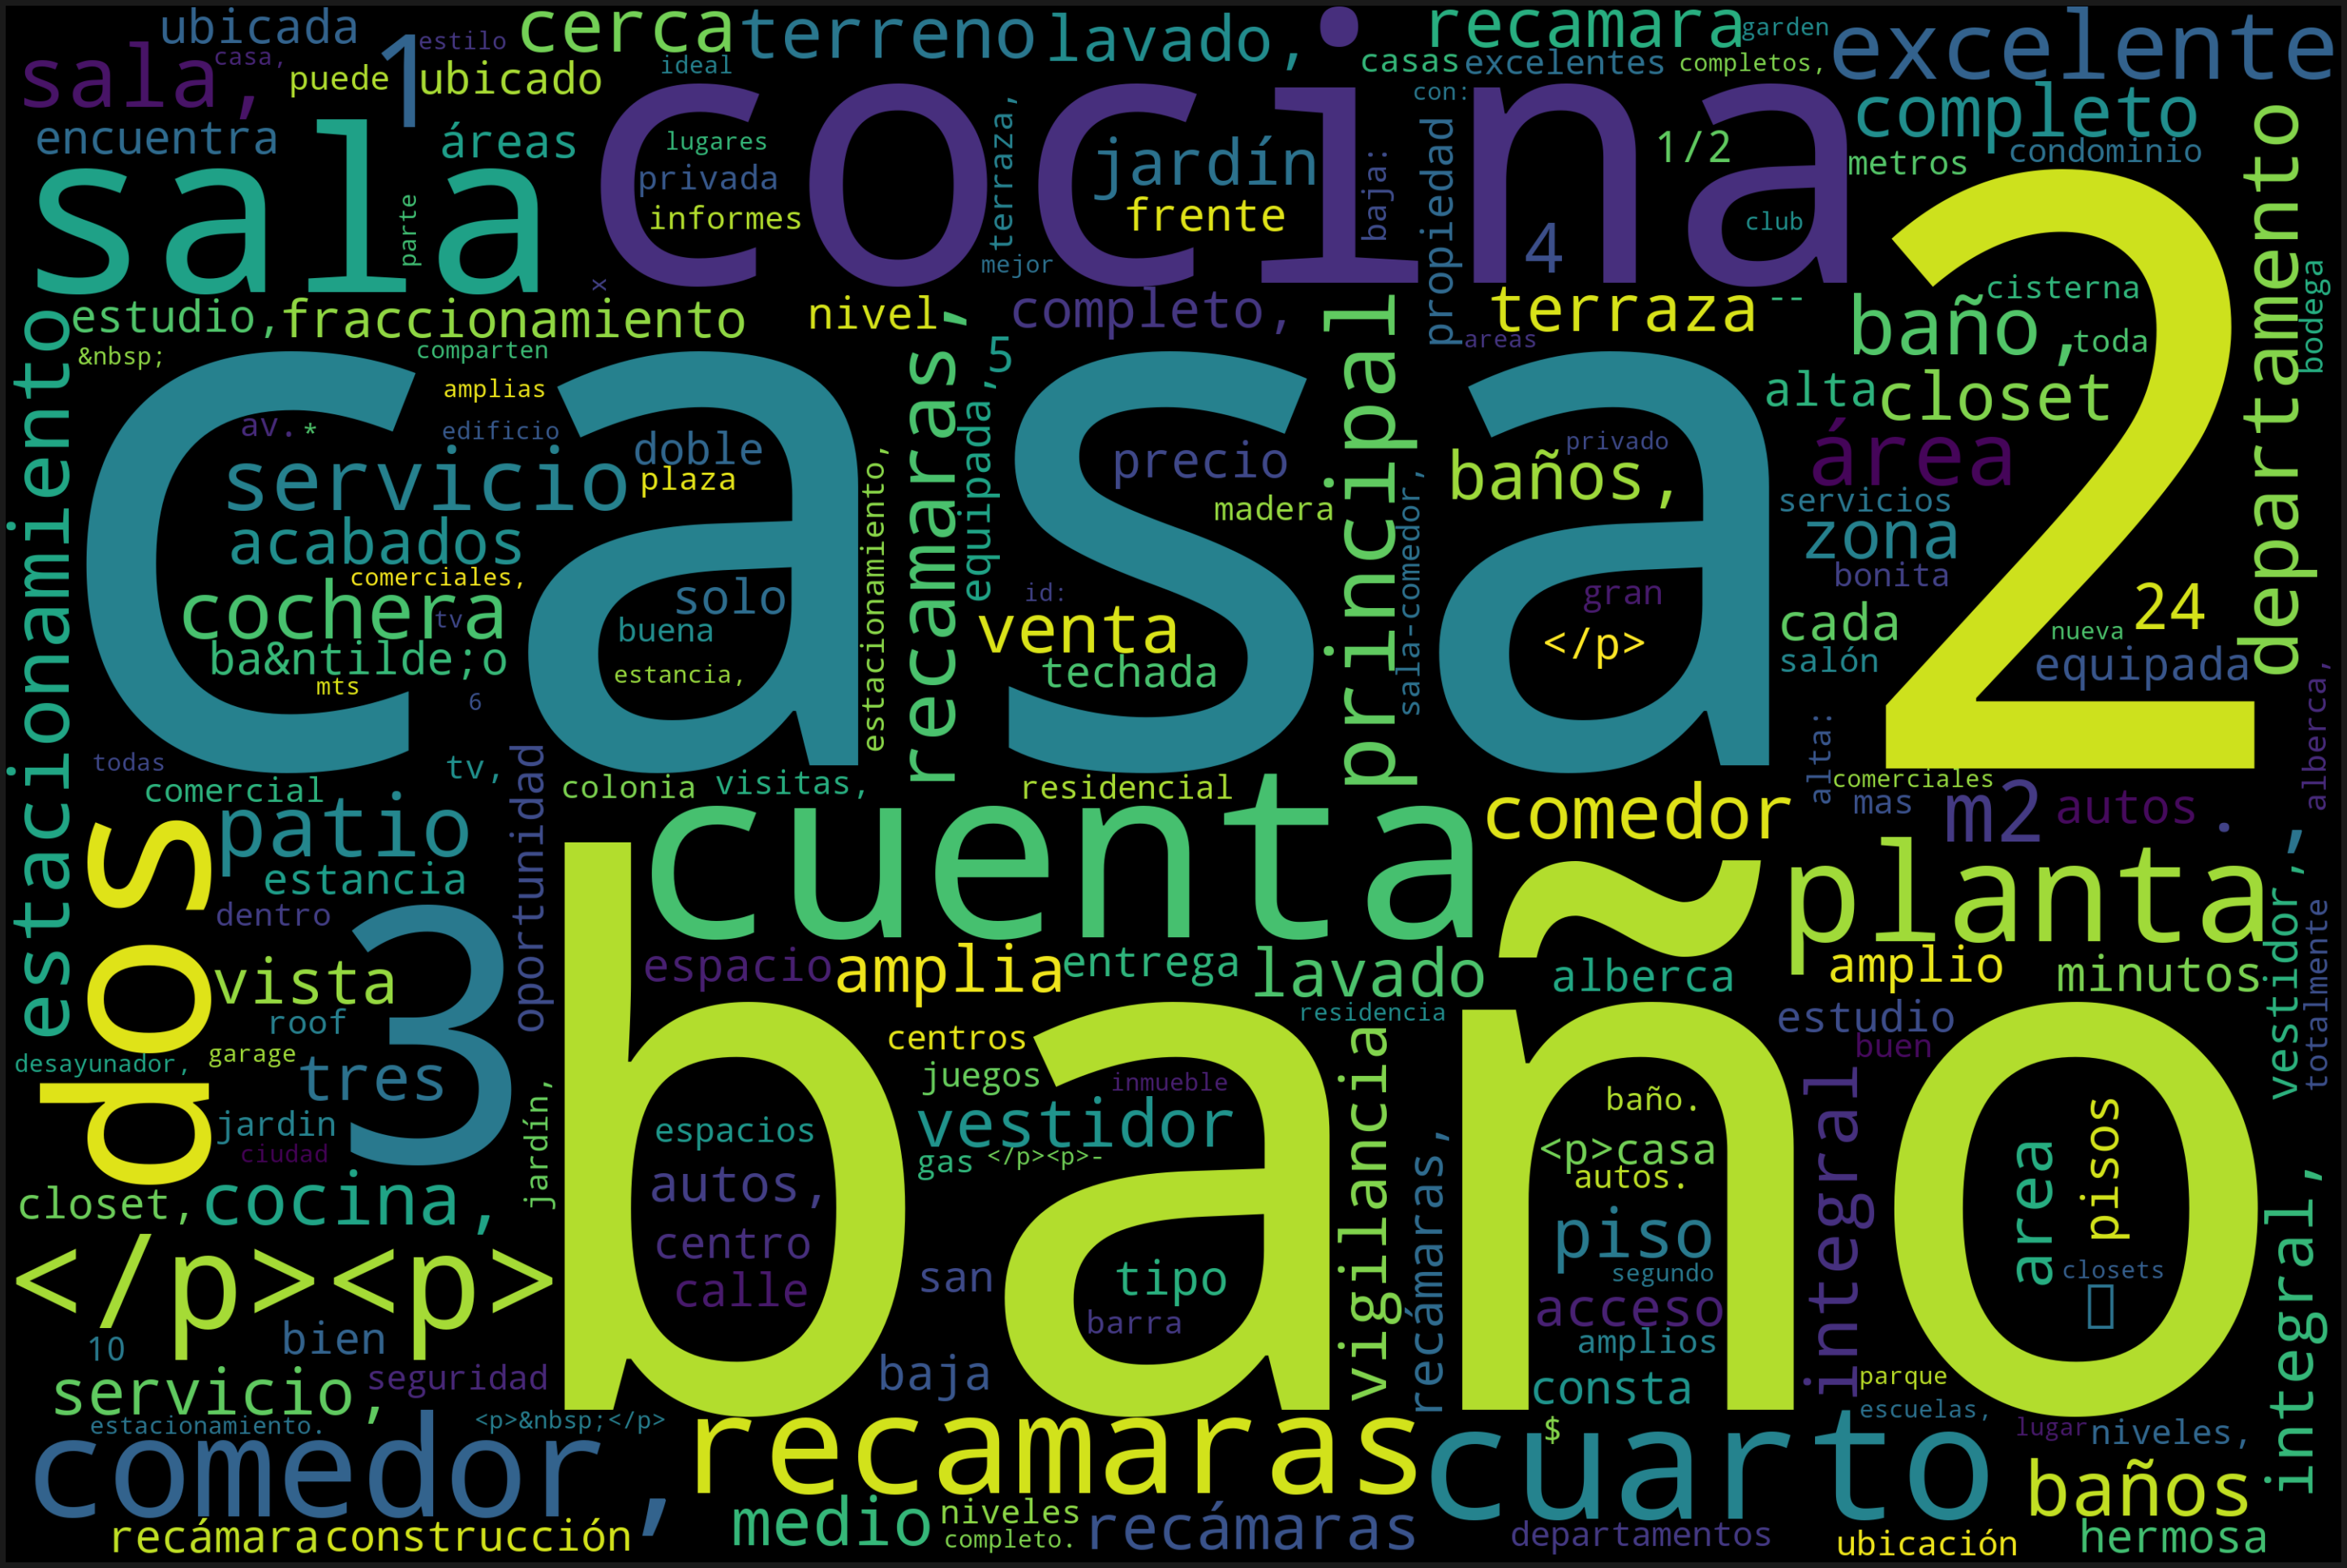

In [25]:
wordcloud_freq(dict_palabras_descripcion)

## Búsqueda palabras clave

In [26]:
# helpers

In [27]:
def contiene(df, columna, palabra):
    return df[columna].str.contains(palabra).astype(int)

In [28]:
def contiene_alguna(df, columna, palabras):
    result = df[columna].apply(lambda x: 0)
    for palabra in palabras:
        result = result | contiene(df, columna, palabra)
        
    return result    

In [29]:
df["descripcion"].loc[239984]

' en excelente ubicación zona mitras centro. amplia  ideal para oficinas o negocio en excelente ubicación en col. progreso (zona mitras centro), monterrey. a unas cuadras de leones, av. simón bolívar, ruíz cortines y av. madero. tiene 1 planta, 2 recamaras, 1 baño, 62 m2 de construcción y 65 m2 de terreno. solo pago de contado. interesados llamar al teléfono  y cel. , o enviar un correo electrónico a '

In [30]:
# del wordcloud
df["palabra_hermosa"] = contiene_alguna(df, "descripcion", ["hermosa", "bonita", "bonito", "linda", "cholula", "cholulo", "preciosa", "precioso"]) | contiene_alguna(df, "titulo", ["hermosa", "bonita", "bonito", "linda", "cholula", "cholulo", "precioso", "preciosa"])
df["palabra_excelente"] = contiene_alguna(df, "descripcion", ["excelente", "excelentes"]) | contiene_alguna(df, "titulo", ["excelente", "excelentes"])
df["palabra_mejor"] = contiene_alguna(df, "descripcion", ["mejor", "mejores"]) | contiene_alguna(df, "titulo", ["mejor", "mejores"])
df["palabra_grande"] = contiene_alguna(df, "descripcion", ["grande", "gran", "amplia", "amplias", "amplio", "amplios"]) | contiene_alguna(df, "titulo", ["grande", "gran", "amplia", "amplias", "amplio", "amplios"])
df["palabra_equipada"] = contiene_alguna(df, "descripcion", ["equipada", "equipado", "completa", "completo"]) | contiene_alguna(df, "descripcion", ["equipada", "equipado", "completa", "completo"])
df["palabra_vestidor"] = contiene_alguna(df, "descripcion", ["vestidor", "closet"]) | contiene_alguna(df, "titulo", ["vestidor", "closet"])
df["palabra_credito"] = contiene_alguna(df, "descripcion", ["credito", "crédito", "créditos", "creditos", "banco", "banca", "bancario", "bancarios", "hipoteca"]) | contiene_alguna(df, "titulo", ["credito", "crédito", "créditos", "creditos", "banco", "banca", "bancario", "bancarios", "hipoteca"])
df["palabra_privada"] = contiene_alguna(df, "descripcion", ["privada", "privado"]) | contiene_alguna(df, "titulo", ["privada", "privado"])
df["palabra_bodega"] = contiene_alguna(df, "descripcion", ["bodega"]) | contiene_alguna(df, "titulo", ["bodega"])
df["palabra_club"] = contiene_alguna(df, "descripcion", ["club"]) | contiene_alguna(df, "titulo", ["club"])
df["palabra_cerrada"] = contiene_alguna(df, "descripcion", ["cerrada", "cerrado"]) | contiene_alguna(df, "titulo", ["cerrada", "cerrado"])
df["palabra_jardin"] = contiene_alguna(df, "descripcion", ["jardin", "jardín", "garden", "patio"]) | contiene_alguna(df, "titulo", ["jardin", "jardín", "garden", "patio"])
df["palabra_oportunidad"] = contiene_alguna(df, "descripcion", ["oportunidad"]) | contiene_alguna(df, "titulo", ["oportunidad"])
df["palabra_tv"] = contiene_alguna(df, "descripcion", ["tv", "tele", "television", "televisión", "televisor"]) | contiene_alguna(df, "titulo", ["tv", "tele", "television", "televisión", "televisor"])
df["palabra_juegos"] = contiene_alguna(df, "descripcion", ["juego"]) | contiene_alguna(df, "titulo", ["juego"])
df["palabra_niño"] = contiene_alguna(df, "descripcion", ["niño", "niña", "infantil"]) | contiene_alguna(df, "titulo", ["niño", "niña", "infantil"])
df["palabra_transporte"] = contiene_alguna(df, "descripcion", ["transporte"]) | contiene_alguna(df, "titulo", ["transporte"])
df["palabra_estudio"] = contiene_alguna(df, "descripcion", ["estudio"]) | contiene_alguna(df, "titulo", ["estudio"])
df["palabra_terraza"] = contiene_alguna(df, "descripcion", ["terraza"]) | contiene_alguna(df, "titulo", ["terraza"])
df["palabra_balcon"] = contiene_alguna(df, "descripcion", ["balcón", "balcon"]) | contiene_alguna(df, "titulo", ["balcón", "balcon"])
df["palabra_lote"] = contiene_alguna(df, "descripcion", ["lote", "terreno"]) | contiene_alguna(df, "titulo", ["lote", "terreno"])
df["palabra_fraccionamiento"] = contiene_alguna(df, "descripcion", ["fraccionamiento", "fracc"]) | contiene_alguna(df, "titulo", ["fraccionamiento", "fracc"])
df["palabra_local"] = contiene_alguna(df, "descripcion", ["local", "tienda", "comercial"]) | contiene_alguna(df, "titulo", ["local", "tienda", "comercial"])
df["palabra_seguridad"] = contiene_alguna(df, "descripcion", ["vigilancia", "vigilador", "seguridad", "guardia"]) | contiene_alguna(df, "titulo", ["vigilancia", "vigilador", "seguridad", "guardia"])
df["palabra_garage"] = contiene_alguna(df, "descripcion", ["garage", "auto", "estacionamiento"]) | contiene_alguna(df, "titulo", ["garage", "auto", "estacionamiento"])
df["palabra_centro"] = contiene_alguna(df, "descripcion", ["centro", "central", "cercano", "cercania", "minuto"]) | contiene_alguna(df, "titulo", ["centro", "central", "cercano", "cercania", "minuto"])
df["palabra_techada"] = contiene_alguna(df, "descripcion", ["techada", "techado", "roof"]) | contiene_alguna(df, "titulo", ["techada", "techado", "roof"])
df["palabra_estancia"] = contiene_alguna(df, "descripcion", ["estancia"]) | contiene_alguna(df, "titulo", ["estancia"])
df["palabra_alberca"] = contiene_alguna(df, "descripcion", ["alberca"]) | contiene_alguna(df, "titulo", ["alberca"])
df["palabra_servicios"] = contiene_alguna(df, "descripcion", ["servicios"]) | contiene_alguna(df, "titulo", ["servicios"])
df["palabra_servicio"] = contiene_alguna(df, "descripcion", ["servicio"]) | contiene_alguna(df, "titulo", ["servicio"])
df["palabra_estilo"] = contiene_alguna(df, "descripcion", ["estilo"]) | contiene_alguna(df, "titulo", ["estilo"])
df["palabra_frente"] = contiene_alguna(df, "descripcion", ["frente"]) | contiene_alguna(df, "titulo", ["frente"])
df["palabra_vista"] = contiene_alguna(df, "descripcion", ["vista"]) | contiene_alguna(df, "titulo", ["vista"])
df["palabra_visitas"] = contiene_alguna(df, "descripcion", ["visita"]) | contiene_alguna(df, "titulo", ["visita"])
df["palabra_parque"] = contiene_alguna(df, "descripcion", ["parque", "plaza", "verde"]) | contiene_alguna(df, "titulo", ["parque", "plaza", "verde"])
df["palabra_areas"] = contiene_alguna(df, "descripcion", ["area", "área"]) | contiene_alguna(df, "titulo", ["area", "área"])
df["palabra_estrenar"] = contiene_alguna(df, "descripcion", ["estrenar", "estreno", "estrene"]) | contiene_alguna(df, "titulo", ["estrenar", "estreno", "estrene"])
df["palabra_infonavit"] = contiene_alguna(df, "descripcion", ["infonavit"]) | contiene_alguna(df, "titulo", ["infonavit"])
df["palabra_residencial"] = contiene_alguna(df, "descripcion", ["residencia"]) | contiene_alguna(df, "titulo", ["residencia"])
df["palabra_escuela"] = contiene_alguna(df, "descripcion", ["escuela", "colegio", "educacion", "educación", "uni", "universidad", "facultad"]) | contiene_alguna(df, "titulo", ["escuela", "colegio", "educacion", "educación", "uni", "universidad", "facultad"])
df["palabra_exclusivo"] = contiene_alguna(df, "descripcion", ["exclusivo", "exclusividad"]) | contiene_alguna(df, "titulo", ["exclusivo", "exclusividad"])
df["palabra_lujo"] = contiene_alguna(df, "descripcion", ["lujo"]) | contiene_alguna(df, "titulo", ["lujo"])
df["palabra_esquina"] = contiene_alguna(df, "descripcion", ["esquina"]) | contiene_alguna(df, "titulo", ["esquina"])
df["palabra_refaccion"] = contiene_alguna(df, "descripcion", ["refaccion", "refacción", "reacondicionado", "remodelada", "remodelado"]) | contiene_alguna(df, "titulo", ["refaccion", "refacción", "reacondicionado", "remodelada", "remodelado"])
df["palabra_country"] = contiene_alguna(df, "descripcion", ["country"]) | contiene_alguna(df, "titulo", ["country"])
df["palabra_barra"] = contiene_alguna(df, "descripcion", ["barra"]) | contiene_alguna(df, "titulo", ["barra"])
df["palabra_lavado"] = contiene_alguna(df, "descripcion", ["lavado"]) | contiene_alguna(df, "titulo", ["lavado"])
df["palabra_renta"] = contiene_alguna(df, "descripcion", ["renta", "alquiler", "alquilar"]) | contiene_alguna(df, "titulo", ["renta", "alquiler", "alquilar"])
df["palabra_super"] = contiene_alguna(df, "descripcion", ["super"]) | contiene_alguna(df, "titulo", ["super"])
df["palabra_lago"] = contiene_alguna(df, "descripcion", ["lago"]) | contiene_alguna(df, "titulo", ["lago"])
df["palabra_bosque"] = contiene_alguna(df, "descripcion", ["bosque", "arbol", "árbol"]) | contiene_alguna(df, "titulo", ["bosque", "arbol", "árbol"])
df["palabra_avenida"] = contiene_alguna(df, "descripcion", ["av", "avenida"]) | contiene_alguna(df, "titulo", ["av", "avenida"])
df["palabra_hospital"] = contiene_alguna(df, "descripcion", ["hospital", "medicina", "medico", "médico", "farmacia"]) | contiene_alguna(df, "titulo", ["hospital", "medicina", "medico", "médico", "farmacia"])
df["palabra_pileta"] = contiene_alguna(df, "descripcion", ["pileta", "piscina", "jacuzzi"]) | contiene_alguna(df, "titulo", ["pileta", "piscina", "jacuzzi"])
df["palabra_solarium"] = contiene_alguna(df, "descripcion", ["solarium"]) | contiene_alguna(df, "titulo", ["solarium"])
df["palabra_gas"] = contiene_alguna(df, "descripcion", ["gas", "estufa"]) | contiene_alguna(df, "titulo", ["gas", "estufa"])




In [31]:
df.to_csv("../data/palabras.csv", index=False)

In [119]:
df["descripcion"].loc[1]

'<p>entre sonora y guerrero, atr&aacute;s del hospital &aacute;ngeles del pedregal, en excelente estado de conservaci&oacute;n, construida en 3 niveles, estacionamiento para 2 autos, 3 rec&aacute;maras con pisos de madera natural la principal con vestidor y ba&ntilde;o, 2 ba&ntilde;os completos pisos y muros de loseta espa&ntilde;ola, canceler&iacute;a de aluminio, 2 medios ba&ntilde;os, cocina integral con piso de loseta espa&ntilde;ola, sala de t.v., sala con piso de loseta espa&ntilde;ola, vest&iacute;bulo, comedor con piso de madera, l&iacute;nea telef&oacute;nica, terraza techada con policarbonato puede ser antecomedor, cuarto de servicio con piso de loseta, fachada con policarbonato..&nbsp; 4 casas</p>'

# TODO: parseo de chars encodeados (&iacute por í, por ejemplo)
# TODO: más palabras para ir probando